In [43]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import heapq



array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [61]:
MAX_ITER = 64

eps = 1.19209e-07


cp_n = 0
cnx = []
nx = {}

#range_array = []

def get_possibilities(n, p):
    global cp_n, cnx, nx
    if cp_n != n:
        cp_n = n
        cnx = np.zeros(n+1)
        cnx[0] = 1.0
        for i in range(1, n+1):
            cnx[i] = cnx[i-1] * (n - i + 1) / i
        nx = {}
    if p not in nx:
        ps = np.zeros(n+1)
        for i in range(n+1):
            ps[i] = cnx[i] * (p**i) * ((1-p)**(n-i))
        nx[p] = ps
    return nx[p]
    
def compute_possibility(n, p, x):
    nx = get_possibilities(n, p)
    return nx[x]

def compute_confidence(n, L, t, p):
    nx = get_possibilities(n, p)
    s = np.sum(nx[(L <= p) & ((L + t) >= p)])
    return s
        
def bs_next_helper(n, c, t, L, m, p):  
    nx = get_possibilities(n, p)
    nx = nx[:m+1]
    Lm = L[:m+1]
    s = np.sum(nx[(Lm <= p) & ((Lm + t) >= p)])
    #s = np.sum(nx[(L <= p) & ((L + t) >= p)])
    if s >= c:
        return True
    return False

#print(bs_next_helper(10, 0.9, 1.0, [0.0,0.0], 0, 0.0001))

def bs_next(n, c, t, L, i, hq):
    if len(hq) == 0:
        return 1.0
    
    beg = heapq.heappop(hq)
    while len(hq) > 0:
        end = heapq.heappop(hq)
        #print(end, bs_next_helper(n, c, t, L, i, end))
        if bs_next_helper(n, c, t, L, i, end):
            beg = end
            continue
        
        if bs_next_helper(n, c, t, L, i, end - eps):
            beg = end - eps
        else:
            for _ in range(MAX_ITER):
                mid = (beg + end) / 2.0
                if mid == beg:
                    break
                #print("mid:", mid, L[0], t, c, bs_next_helper(n, c, t, L, i+1, mid))
                if bs_next_helper(n, c, t, L, i, mid):
                    beg = mid
                else:
                    end = mid
        
        heapq.heappush(hq, beg)
        heapq.heappush(hq, min(1.0, beg+t+eps))
        L[i+1] = beg
        if not bs_next_helper(n, c, t, L, i+1, end):
            heapq.heappush(hq, end)
        return beg
    
    return 1.0
        

def bci_helper(n, c, t, L):
    #L -= 3.0
    L[0] = 0.0
    
    # wrong
    #hq = [0.0, 1.0]
    
    hq = [i / n for i in range(n+1)]
    
    heapq.heappush(hq, t)
    for i in range(n):
        L[i+1] = bs_next(n, c, t, L, i, hq)
        #print(hq)
    
    #tmp = test_bci(n, L, t, 0.01)
    #if tmp >= c:
    #    return True
    #return False
    
    while len(hq) > 0:
        p = heapq.heappop(hq)
        if compute_confidence(n, L, t, p) < c:
            return False
        if p == 1.0:
            break
    return True

def compute_binomail_confidence_interval(n, c):
    #global range_array
    #range_array = np.array(range(n))
    L = np.zeros(n+1)
    beg = 0.0
    end = 1.0
    for i in range(MAX_ITER):
        mid = (beg + end) / 2.0
        if mid == beg:
            break
        ok = bci_helper(n, c, mid, L)
        print(i, mid, ok)
        if ok:
            end = mid
        else:
            beg = mid
    bci_helper(n, c, end, L)
    return L, L + end, end

            

def test_bci(n, L, t, step):
    ret = compute_confidence(n, L, t, 1.0)
    ind = 1.0
    p = 0
    while p <= 1.0:
        tmp = compute_confidence(n, L, t, p)
        if tmp < ret:
            ret = tmp
            ind = p
        p += step
    return ret, ind

def compute_and_test(n, c, step):
    L, R, t = compute_binomail_confidence_interval(n, c)
    ret, ret_p = test_bci(n, L, t, step)
    print("result:", c, ret, ret_p)
    return L, R, t

# compute_binomail_confidence_interval(10, 0.9)  
# %time L, R, t = compute_and_test(200, 0.99, 0.01)


0 0.5 True
1 0.25 True
2 0.125 False
3 0.1875 False
4 0.21875 False
5 0.234375 False
6 0.2421875 True
7 0.23828125 False
8 0.240234375 False
9 0.2412109375 False
10 0.24169921875 False
11 0.241943359375 True
12 0.2418212890625 True
13 0.24176025390625 False
14 0.241790771484375 False
15 0.2418060302734375 True
16 0.24179840087890625 True
17 0.24179458618164062 False
18 0.24179649353027344 True
19 0.24179553985595703 False
20 0.24179601669311523 False
21 0.24179625511169434 False
22 0.2417963743209839 False
23 0.24179643392562866 False
24 0.24179646372795105 True
25 0.24179644882678986 True
26 0.24179644137620926 False
27 0.24179644510149956 True
28 0.2417964432388544 True
29 0.24179644230753183 True
30 0.24179644184187055 True
31 0.2417964416090399 False
32 0.24179644172545522 True
33 0.24179644166724756 True
34 0.24179644163814373 False
35 0.24179644165269565 True
36 0.2417964416454197 True
37 0.2417964416417817 False
38 0.2417964416436007 True
39 0.2417964416426912 False
40 0.2417964

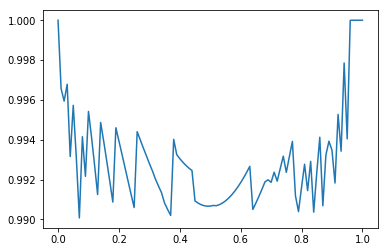

In [48]:
n = 100
c = 0.99
steps = 100
L, R, t = compute_and_test(n, c, (1.0 / steps))
print("interval:", t)
x = [i * (1.0 / steps) for i in range(steps+1)]
y = [compute_confidence(n, L, t, i) for i in x]
#print(x, y)

plt.plot(x,y)
#for i,j in zip(x, y):
#    print(i,j)